Author: Xi Ming.

## Build a GAN from Scratch based on PyTorch.

### Import Packages.

In [12]:
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas

print('pytorch version:',torch.__version__,
      '\nmatplotlib version:' ,matplotlib.__version__,
      '\nnumpy version:' ,np.__version__)

pytorch version: 1.7.1+cu101 
matplotlib version: 3.2.1 
numpy version: 1.18.2


### Settings
We define some hyperparameters here.

In [13]:
# model runs on  GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rate = 1e-2
momentum = 0.9
num_epochs = 10
batch_size = 128

# Architecture
num_features = 784
num_hidden = 200
num_classes = 10

### Dataset: MNIST

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])

Show images: 


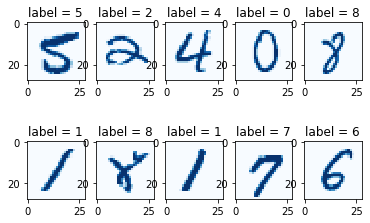

In [14]:
train_dataset = datasets.MNIST(root='data',
                               train=True, download=True,
                               transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))]))

test_dataset = datasets.MNIST(root='data',
                              train=False, download=True,
                              transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))]))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size, shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    # plot img.
    print("\nShow images: ")
    plt.figure()
    for i in range(1, 11):
        img = images[i].numpy()
        img = img.reshape(28,28)
        plt.subplot(2,5,i)
        plt.title("label = " + str(labels[i].numpy()))
        plt.imshow(img, interpolation='none', cmap='Blues')
    plt.show()
    break

### Discriminator Network

In [15]:
class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02, inplace=True),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        # move data to device('cpu' or 'gpu') and reshape images
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.view(-1, 28*28)

        # calculate the output of the network
        outputs = self.forward(inputs)
        # outputs = outputs.squeeze(-1)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.data.item())
        if self.counter % 10000 == 0:
            print("counter = ", self.counter)

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

### Test Discriminator

In [22]:
%%time
# functions to generate random data
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

# test discriminator can separate real data from random noise
D = Discriminator().to(device)

for images, labels in train_loader:
    # real data
    a = torch.ones(batch_size).resize_(batch_size, 1)
    print(a.shape, images.shape)
    D.train(images, a)
    # fake data
    D.train(generate_random_image(784), torch.FloatTensor([0.0]))

torch.Size([128, 1]) torch.Size([128, 1, 28, 28])


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.

In [17]:
# plot discriminator loss
D.plot_progress()

TypeError: no numeric data to plot

### Generator Network

In [ ]:
# generator class
class Generator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02, inplace=True),
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # simply run model
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # calculate the output of the network
        inputs = inputs.view(-1, 28*28)
        g_output = self.forward(inputs)

        # pass onto Discriminator
        d_output = D.forward(g_output)

        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.data.item())

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

### Test Generator Output

In [ ]:
%%time
# functions to generate random data
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

# check the generator output is of the right type and shape
G = Generator()
output = G.forward(generate_random_seed(100))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation='none', cmap='Blues')

### Train GAN

In [ ]:
%%time

# create Discriminator and Generator
D = Discriminator().to(device)
G = Generator().to(device)

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator
  for images, labels in train_loader:
    # train discriminator on true
    D.train(images, torch.FloatTensor([1.0]))

    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))

    # train generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

In [ ]:
# plot discriminator error
D.plot_progress()

In [ ]:
# plot generator error
G.plot_progress()

### Run Generator

In [ ]:
# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')